In [2]:
import pandas as pd
import numpy as np
import itertools
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#pip install pmdarima --user

In [4]:
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from pmdarima import auto_arima
import modules.ts_util as util
                   

In [5]:
df = pd.read_csv('data/GlobalTemperatures.csv', parse_dates=True, index_col='dt').dropna(how='any')
df.head()

,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
dt,,,,,,,,
1850-01-01,0.749,1.105,8.242,1.738,-3.206,2.822,12.833,0.367
1850-02-01,3.071,1.275,9.970,3.007,-2.291,1.623,13.588,0.414
1850-03-01,4.954,0.955,10.347,2.401,-1.905,1.410,14.043,0.341
1850-04-01,7.217,0.665,12.934,1.004,1.018,1.329,14.667,0.267
1850-05-01,10.004,0.617,15.655,2.406,3.811,1.347,15.507,0.249


In [6]:
df_M = df.resample('MS').mean()#.fillna(0)

df_M.head()

,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
dt,,,,,,,,
1850-01-01,0.749,1.105,8.242,1.738,-3.206,2.822,12.833,0.367
1850-02-01,3.071,1.275,9.970,3.007,-2.291,1.623,13.588,0.414
1850-03-01,4.954,0.955,10.347,2.401,-1.905,1.410,14.043,0.341
1850-04-01,7.217,0.665,12.934,1.004,1.018,1.329,14.667,0.267
1850-05-01,10.004,0.617,15.655,2.406,3.811,1.347,15.507,0.249


In [7]:
print(util.get_adf_test_outputs(df_M['LandAverageTemperature']))

ADF Test Statistic        -1.455328
p-value                    0.555483
# Lags Used               26.000000
# Observations Used     1965.000000
Critical Value (1%)       -3.433682
Critical Value (5%)       -2.863012
Critical Value (10%)      -2.567554
dtype: float64


In [8]:
df_M.corr()['LandAverageTemperature']

LandAverageTemperature                       1.000000
LandAverageTemperatureUncertainty           -0.143129
LandMaxTemperature                           0.995807
LandMaxTemperatureUncertainty               -0.108462
LandMinTemperature                           0.995611
LandMinTemperatureUncertainty               -0.167451
LandAndOceanAverageTemperature               0.988066
LandAndOceanAverageTemperatureUncertainty   -0.131412
Name: LandAverageTemperature, dtype: float64

In [9]:
df_M = df_M[['LandAverageTemperature','LandMaxTemperature','LandMinTemperature','LandAndOceanAverageTemperature']]
df_M.head()

,LandAverageTemperature,LandMaxTemperature,LandMinTemperature,LandAndOceanAverageTemperature
dt,,,,
1850-01-01,0.749,8.242,-3.206,12.833
1850-02-01,3.071,9.970,-2.291,13.588
1850-03-01,4.954,10.347,-1.905,14.043
1850-04-01,7.217,12.934,1.018,14.667
1850-05-01,10.004,15.655,3.811,15.507


In [10]:
train=df_M[:round(df_M.shape[0]*80/100)]['LandAverageTemperature']
test=df_M[round(df_M.shape[0]*80/100):]['LandAverageTemperature']

train_exog=df_M[:round(df_M.shape[0]*80/100)][['LandMaxTemperature','LandMinTemperature','LandAndOceanAverageTemperature']]
test_exog=df_M[round(df_M.shape[0]*80/100):][['LandMaxTemperature','LandMinTemperature','LandAndOceanAverageTemperature']]

print(train.shape, test.shape)

(1594,) (398,)


In [161]:
stepwise_fit_1 = auto_arima(train, seasonal=True, m=12, trace=True, stationary=False)
stepwise_fit_1

Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(1,0,1,12) [intercept=True]; AIC=1456.677, BIC=1499.669, Time=16.015 seconds
Fit ARIMA(0,0,0)x(0,0,0,12) [intercept=True]; AIC=9159.467, BIC=9170.215, Time=0.062 seconds
Fit ARIMA(1,0,0)x(1,0,0,12) [intercept=True]; AIC=2084.033, BIC=2105.529, Time=9.057 seconds
Near non-invertible roots for order (1, 0, 0)(1, 0, 0, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA(0,0,1)x(0,0,1,12) [intercept=True]; AIC=5900.631, BIC=5922.127, Time=2.918 seconds
Fit ARIMA(0,0,0)x(0,0,0,12) [intercept=False]; AIC=11676.853, BIC=11682.227, Time=0.048 seconds
Fit ARIMA(2,0,2)x(0,0,1,12) [intercept=True]; AIC=1886.435, BIC=1924.053, Time=13.950 seconds
Fit ARIMA(2,0,2)x(1,0,0,12) [intercept=True]; AIC=2044.918, BIC=2082.536, Time=12.635 seconds
Near non-invertible roots for order (2, 0, 2)(1, 0, 0, 12); setting score to inf (at least one inverse root too close to the border of the un

ARIMA(maxiter=50, method='lbfgs', order=(1, 0, 1), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(2, 0, 2, 12),
      start_params=None, suppress_warnings=False, trend=None,
      with_intercept=True)

In [168]:
order=(1, 0, 1)#stepwise_fit_1.order
seasonal_order=(2, 0, 2, 12)#stepwise_fit_1.seasonal_order

pred_results=SARIMAX(train, order=order, seasonal_order=seasonal_order, \
                      enforce_stationarity=True, enforce_invertibility=False).fit()
pred_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                  LandAverageTemperature   No. Observations:                 1594
Model:             SARIMAX(1, 0, 1)x(2, 0, [1, 2], 12)   Log Likelihood                -762.560
Date:                                 Thu, 14 May 2020   AIC                           1539.121
Time:                                         21:19:01   BIC                           1576.739
Sample:                                     01-01-1850   HQIC                          1553.092
                                          - 10-01-1982                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7944    4.3e-05   1.85e+04      0.000       0.794       0.795
ma.L1         17.7481      0.332     53.401      0.000      17.097      18.400
ar.S.L12       0.0027   5.64e-06    486.153      0.000       0.003       0.003
ar.S.L24       0.9972   1.06e-05    9.4e+04      0.000       0.997       0.997
ma.S.L12       0.0632      0.002     33.883      0.000       0.060       0.067
ma.S.L24      -0.9374    8.1e-05  -1.16e+04      0.000      -0.938      -0.937
sigma2         0.0004   1.39e-05     32.110      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                      280.20   Jarque-Bera (JB):               343.86
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.50   Skew:                            -0.00
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [169]:
start = len(train)
end = len(train) + len(test) - 1
print(start, end)

predictions = pred_results.predict(start=start, end=end, typ='levels', dynamic=True).rename('SARIMA Predictions')

test.to_frame().join(predictions).tail(10)

1594 1991


,LandAverageTemperature,SARIMA Predictions
dt,,
2015-03-01,6.740,5.324586
2015-04-01,9.313,8.499606
2015-05-01,12.312,11.333875
2015-06-01,14.505,13.438192
2015-07-01,15.051,14.364785
2015-08-01,14.755,13.843205
2015-09-01,12.999,12.048969
2015-10-01,10.801,9.350943
2015-11-01,7.433,6.125663


Text(0.5, 1.0, 'RMS Error = 0.7335712901415216')

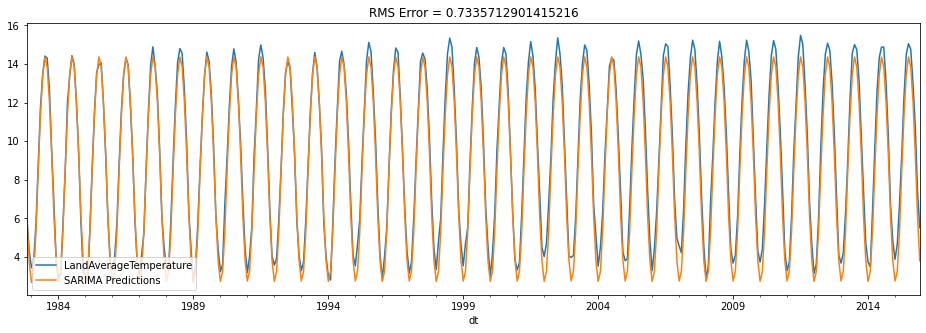

In [185]:
mse, rmse = util.measure_pred_errors(test,predictions)
test.plot(legend=True, figsize=(16,5));
predictions.plot( legend=True);
plt.legend(loc=3)
plt.title('RMS Error = {}'.format(rmse))

In [152]:
stepwise_fit_2 = auto_arima(train, seasonal=True, m=12, trace=True, \
                            stationary=False, exogenous=train_exog)
stepwise_fit_2

Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(1,0,1,12) [intercept=True]; AIC=-485.783, BIC=-421.302, Time=7.969 seconds
Fit ARIMA(0,1,0)x(0,0,0,12) [intercept=True]; AIC=49.830, BIC=82.070, Time=1.279 seconds
Fit ARIMA(1,1,0)x(1,0,0,12) [intercept=True]; AIC=-242.436, BIC=-199.449, Time=4.812 seconds
Fit ARIMA(0,1,1)x(0,0,1,12) [intercept=True]; AIC=-175.880, BIC=-132.893, Time=5.482 seconds
Fit ARIMA(0,1,0)x(0,0,0,12) [intercept=False]; AIC=49.830, BIC=82.070, Time=1.754 seconds
Fit ARIMA(2,1,2)x(0,0,1,12) [intercept=True]; AIC=-371.833, BIC=-312.726, Time=6.851 seconds
Fit ARIMA(2,1,2)x(1,0,0,12) [intercept=True]; AIC=-443.962, BIC=-384.855, Time=7.559 seconds
Fit ARIMA(2,1,2)x(2,0,1,12) [intercept=True]; AIC=-512.049, BIC=-442.196, Time=24.397 seconds
Fit ARIMA(2,1,2)x(2,0,0,12) [intercept=True]; AIC=-502.309, BIC=-437.828, Time=22.233 seconds
Fit ARIMA(2,1,2)x(2,0,2,12) [intercept=True]; AIC=-516.900, BIC=-441.673, Time=24.957 seconds
Fit ARIMA(2,1,2)x(1,0,2,12) [in

ARIMA(maxiter=50, method='lbfgs', order=(0, 1, 5), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(2, 0, 2, 12),
      start_params=None, suppress_warnings=False, trend='ct',
      with_intercept=True)

In [174]:
order=(0, 1, 5)#stepwise_fit_2.order
seasonal_order=(2, 0, 2, 12)#stepwise_fit_2.seasonal_order

pred_results_X=SARIMAX(train, order=order, seasonal_order=seasonal_order, \
                      enforce_stationarity=True, enforce_invertibility=False, exogenous=train_exog).fit()
pred_results_X.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                  LandAverageTemperature   No. Observations:                 1594
Model:             SARIMAX(0, 1, 5)x(2, 0, [1, 2], 12)   Log Likelihood                -621.519
Date:                                 Thu, 14 May 2020   AIC                           1263.039
Time:                                         21:22:07   BIC                           1316.772
Sample:                                     01-01-1850   HQIC                          1282.996
                                          - 10-01-1982                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6192      0.022    -28.352      0.000      -0.662      -0.576
ma.L2         -0.1853      0.023     -8.134      0.000      -0.230      -0.141
ma.L3         -0.0777      0.008     -9.511      0.000      -0.094      -0.062
ma.L4         -0.0338      0.029     -1.185      0.236      -0.090       0.022
ma.L5         -0.0829      0.027     -3.042      0.002      -0.136      -0.029
ar.S.L12       0.1546      0.013     12.099      0.000       0.130       0.180
ar.S.L24       0.8439      0.013     65.243      0.000       0.819       0.869
ma.S.L12      -0.0107      0.020     -0.523      0.601      -0.051       0.029
ma.S.L24      -0.6914      0.026    -26.140      0.000      -0.743      -0.640
sigma2         0.1238      0.003     37.178      0.000       0.117       0.130
===================================================================================
Ljung-Box (Q):                       79.29   Jarque-Bera (JB):               287.70
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.46   Skew:                             0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [182]:
start = len(train)
end = len(train) + len(test) - 1
print(start, end)

predictions_X = pred_results_X.predict(start=start, end=end, typ='levels', dynamic=True).rename('SARIMAX Predictions')

test.to_frame().join(predictions_X).tail(10)

1594 1991


,LandAverageTemperature,SARIMAX Predictions
dt,,
2015-03-01,6.740,5.696108
2015-04-01,9.313,8.808042
2015-05-01,12.312,11.522088
2015-06-01,14.505,13.505645
2015-07-01,15.051,14.453608
2015-08-01,14.755,13.930943
2015-09-01,12.999,12.164883
2015-10-01,10.801,9.485997
2015-11-01,7.433,6.487790


Text(0.5, 1.0, 'RMS Error = 0.5806721075652417')

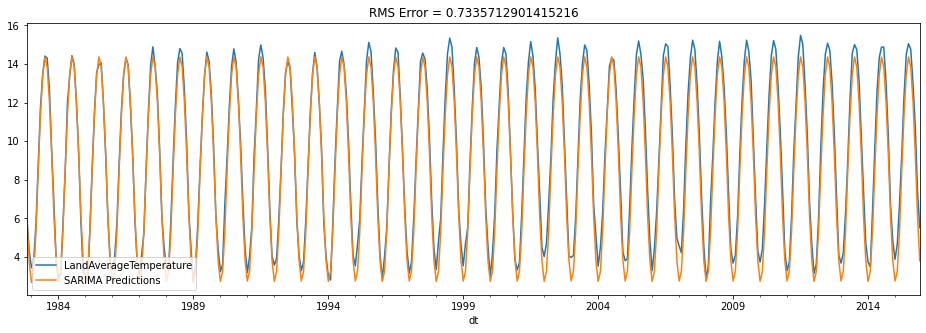

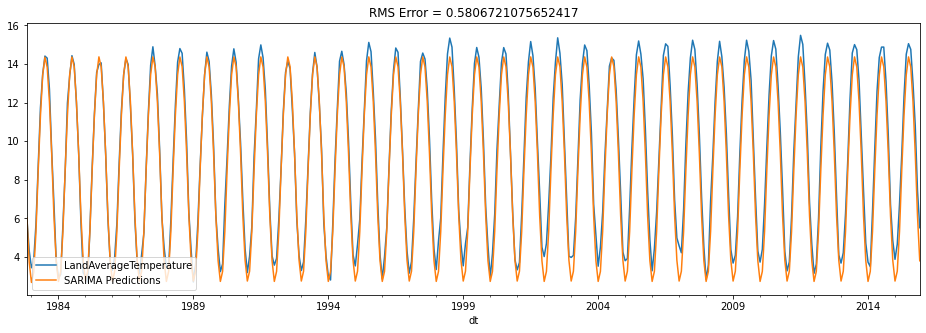

In [183]:
mse, rmse = util.measure_pred_errors(test,predictions)
test.plot(legend=True, figsize=(16,5));
predictions.plot( legend=True);
plt.legend(loc=3)
plt.title('RMS Error = {}'.format(rmse))

mse, rmse = util.measure_pred_errors(test,predictions_X)
test.plot(legend=True, figsize=(16,5));
predictions.plot( legend=True);
plt.legend(loc=3)
plt.title('RMS Error = {}'.format(rmse))

In [179]:
stepwise_fit = auto_arima(df_M['LandAverageTemperature'], seasonal=True, m=12, trace=True, stationary=False)
stepwise_fit

Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(1,0,1,12) [intercept=True]; AIC=2214.637, BIC=2259.408, Time=10.901 seconds
Fit ARIMA(0,1,0)x(0,0,0,12) [intercept=True]; AIC=8841.369, BIC=8852.562, Time=0.081 seconds
Fit ARIMA(1,1,0)x(1,0,0,12) [intercept=True]; AIC=3001.907, BIC=3024.292, Time=8.050 seconds
Near non-invertible roots for order (1, 1, 0)(1, 0, 0, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA(0,1,1)x(0,0,1,12) [intercept=True]; AIC=6222.991, BIC=6245.376, Time=3.693 seconds
Fit ARIMA(0,1,0)x(0,0,0,12) [intercept=False]; AIC=8839.371, BIC=8844.968, Time=0.082 seconds
Fit ARIMA(2,1,2)x(0,0,1,12) [intercept=True]; AIC=2229.952, BIC=2269.127, Time=18.610 seconds
Fit ARIMA(2,1,2)x(1,0,0,12) [intercept=True]; AIC=2676.528, BIC=2715.703, Time=20.333 seconds
Fit ARIMA(2,1,2)x(2,0,1,12) [intercept=True]; AIC=2146.470, BIC=2196.838, Time=56.238 seconds
Fit ARIMA(2,1,2)x(2,0,0,12) [intercept=True]; AIC

ARIMA(maxiter=50, method='lbfgs', order=(0, 1, 1), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(2, 0, 1, 12),
      start_params=None, suppress_warnings=False, trend=None,
      with_intercept=True)

In [180]:
order=stepwise_fit.order
seasonal_order=stepwise_fit.seasonal_order

fc_results=SARIMAX(df_M['LandAverageTemperature'], order=order, seasonal_order=seasonal_order, \
                   enforce_stationarity=True, enforce_invertibility=False).fit()

fc_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:             LandAverageTemperature   No. Observations:                 1992
Model:             SARIMAX(0, 1, 1)x(2, 0, 1, 12)   Log Likelihood                -748.165
Date:                            Thu, 14 May 2020   AIC                           1506.330
Time:                                    21:54:44   BIC                           1534.312
Sample:                                01-01-1850   HQIC                          1516.607
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7763      0.013    -61.493      0.000      -0.801      -0.752
ar.S.L12       0.9408      0.001   1471.323      0.000       0.940       0.942
ar.S.L24       0.0591      0.001     92.275      0.000       0.058       0.060
ma.S.L12      -0.8984      0.011    -84.357      0.000      -0.919      -0.878
sigma2         0.1199      0.001     81.944      0.000       0.117       0.123
===================================================================================
Ljung-Box (Q):                      150.02   Jarque-Bera (JB):               206.06
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.50   Skew:                             0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [181]:
forecast = fc_results.forecast(steps=60, typ='levels').rename('Forecast')
forecast

2016-01-01     4.017124
2016-02-01     4.505930
2016-03-01     6.753045
2016-04-01     9.811917
2016-05-01    12.621558
2016-06-01    14.738618
2016-07-01    15.510246
2016-08-01    15.109532
2016-09-01    13.353235
2016-10-01    10.705194
2016-11-01     7.468167
2016-12-01     5.019378
2017-01-01     4.060667
2017-02-01     4.566809
2017-03-01     6.803567
2017-04-01     9.833388
2017-05-01    12.653918
2017-06-01    14.775238
2017-07-01    15.533446
2017-08-01    15.138965
2017-09-01    13.382876
2017-10-01    10.761723
2017-11-01     7.517303
2017-12-01     5.100331
2018-01-01     4.109677
2018-02-01     4.614740
2018-03-01     6.851868
2018-04-01     9.883079
2018-05-01    12.702660
2018-06-01    14.823499
2018-07-01    15.582418
2018-08-01    15.187611
2018-09-01    13.431699
2018-10-01    10.809240
2018-11-01     7.565609
2018-12-01     5.147018
2019-01-01     4.158359
2019-02-01     4.663430
2019-03-01     6.900295
2019-04-01     9.931096
2019-05-01    12.750428
2019-06-01    14

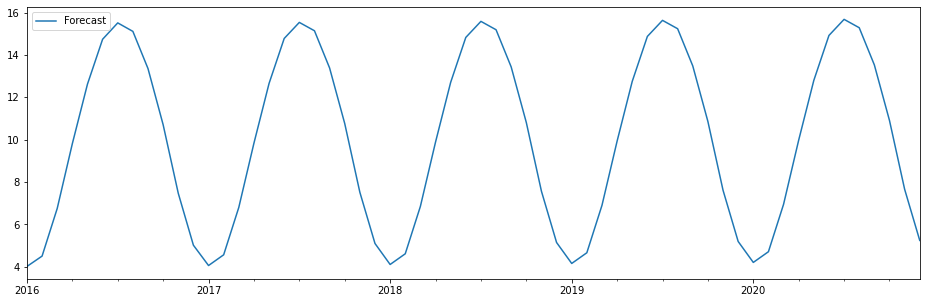

In [187]:
forecast.plot(figsize=(16,5), legend=True)